In [1]:
from IPython.display import Image, HTML

# Loan default prediction

In this tutorial you will use the getML Python API in order to

1. [Approach a real world dataset](#Data-exploration)
2. [Train a single Multirel Model](#Training-a-Multirel-Model)
3. [Perform a Hyperparameter optimization](#Hyperparameter-optimization)
4. [Access the trained features](#Extracting-Features)

The main result is the analysis of a real world problem from the financial sector. You will learn how to tackle a data science problem from scratch to a production ready solution.

### Introduction

This tutorial features a use case from the financial sector. We will use getML in order to predict loan default. A loan is the lending of money to companies or individuals. Banks grant loans in exchange for the promise of repayment. Loan default is defined as the failure to meet this legal obligation, for example when a home buyer fails to make a mortgage payment. It is essential for a bank to estimate the risk it carries when granting loans to potentially non-performing customers.

The analysis is based on the [financial](https://relational.fit.cvut.cz/dataset/Financial) dataset from the [the CTU Prague Relational Learning Repository](https://arxiv.org/abs/1511.03086). It contains information about 606 successful and 76 not successful loans and consists of 8 tables:

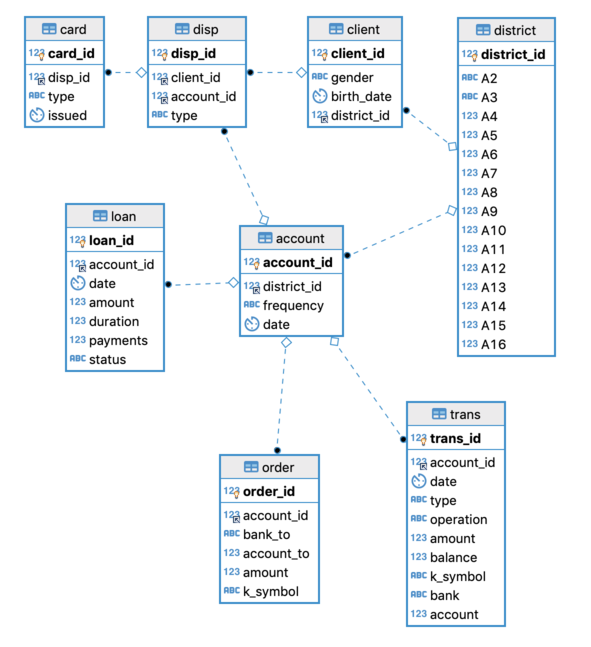

In [2]:
Image(filename="dataset_jupyter.png")

The `loan` table contains information about the loans gratend by th bank, such as date of creation, amount and the planned duration of the loan. It also contains our target variable `status` that we will predict in this analysis. Each loan is associated to one account.

Each account has both static characteristics (e.g. date of creation, address of the branch) given in `account` and dynamic characteristics (e.g. payments debited or credited, balances) given in relations `order` and `trans`. The table `client` describes characteristics of the account owners. Clients and accounts are related together in relation `disp`. The `card` table describes credit card services which the bank offers to its clients. The table `district` gives publicly available information about the districts an account or client is related to (e.g. the unemployment rate). More information about the dataset can be found [here](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm). 

For convenience, we will work with CSV exports from the original database. We have provided a zip archive of the files [here](https://static.get.ml/data/loans.zip). First, we will do some data exploration using [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [3]:
import pandas as pd

DATADIR='../../../data/loans'
loan = pd.read_csv(DATADIR + '/loan.csv')
account = pd.read_csv(DATADIR + '/account.csv')
order = pd.read_csv(DATADIR + '/order.csv')
trans = pd.read_csv(DATADIR + '/trans.csv')
card = pd.read_csv(DATADIR + '/card.csv')
client = pd.read_csv(DATADIR + '/client.csv')
disp = pd.read_csv(DATADIR + '/disp.csv')
district = pd.read_csv(DATADIR + '/district.csv')

/Users/kingj/Software/miniconda3/envs/getML_stable/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data exploration

We will have a closer look at the tables from the financial dataset and simplify the data scheme where possible for later analysis. Such operations are recommended when a join between two tables is possible without any aggregation operations.

### Population table

The target column is `status` in `loan` table. Each loan, however, is associated with exactly one account. Therefore we left join `account` and `loan` and use the result as population table.

In [4]:
population = loan.merge(
    account,
    how='left',
    on='account_id',
    suffixes=('_loan', '_account')
)

This is the resulting population table

In [5]:
display(HTML(population.to_html()))

,loan_id,account_id,date_loan,amount,duration,payments,status,district_id,frequency,date_account
0,4959,2,1994-01-05,80952,24,3373.0,A,1,POPLATEK MESICNE,1993-02-26
1,4961,19,1996-04-29,30276,12,2523.0,B,21,POPLATEK MESICNE,1995-04-07
2,4962,25,1997-12-08,30276,12,2523.0,A,68,POPLATEK MESICNE,1996-07-28
3,4967,37,1998-10-14,318480,60,5308.0,D,20,POPLATEK MESICNE,1997-08-18
4,4968,38,1998-04-19,110736,48,2307.0,C,19,POPLATEK TYDNE,1997-08-08
5,4973,67,1996-05-02,165960,24,6915.0,A,16,POPLATEK MESICNE,1994-10-19
6,4986,97,1997-08-10,102876,12,8573.0,A,74,POPLATEK MESICNE,1996-05-05
7,4988,103,1997-12-06,265320,36,7370.0,D,44,POPLATEK MESICNE,1996-03-10
8,4989,105,1998-12-05,352704,48,7348.0,C,21,POPLATEK MESICNE,1997-07-10
9,4990,110,1997-09-08,162576,36,4516.0,C,36,POPLATEK MESICNE,1996-07-17


The `status` column contains 4 different categories: 

* A stands for contract finished, no problems,
* B stands for contract finished, loan not payed,
* C stands for running contract, OK so far,
* D stands for running contract, client in debt

We will consider A and C a successfull loan and B and D a default and transform `status` into a boolean column. Finally, we will randomly spit the data into a training and a validation set.

In [7]:
import numpy as np

population['status'] = np.where((population['status'] == 'A') | (population['status'] == 'C') , 1, 0)

population_training = population[population['account_id'] % 2 == 0]
population_validation = population[population['account_id'] % 2 == 1]

### Peripheral tables

We will use all the other tables as peripheral tables. Some of them do not have a time stamps so we will add a dummy one. Also we join `card`, `disp`  and `client` in order to simplify the data scheme. Note that `district` is used twice: It is once joined to the population table and once to the `client` table. 

In [8]:
disp_client_card = disp.merge(
                        client,
                        how='left',
                        on='client_id'
                      ).merge(
                        card,
                        how='left',
                        on='disp_id',
                        suffixes=("_disp","_card")
                 )
disp_client_card['dummy_ts'] = 0
district['dummy_ts'] = 0
order['dummy_ts'] = 0

## Training a Multirel Model

After having prepared the dataset we can dive into the actual analysis. This is the point where getML sets in with automated feature engineering and model training. First, we will load the data to the getML engine and define the data scheme. Then we will train a [MultirelModel](https://docs.get.ml/latest/api/getml.models.MultirelModel.html) in order to predict the target column `status`.

### Data loading

So far everything happend within pandas. In order to make best use of getML we upload the data into the engine. To this end we create a [DataFrame](https://docs.get.ml/latest/api/getml.engine.DataFrame.html) for each table. During this step we give a [role](https://docs.get.ml/latest/tutorial/data_frames/on_data_frames.html#roles) to each column. That mean we tell the engine how it should interpret the values of each column. Roles are for example "categorical" oder "numerical" but also include "target" and "join_keys". After initializing each DataFrame in the Python API we send it to the engine with the actual data.

In [9]:
from getml import engine
engine.set_project('loans')

In [10]:
df_population_training = engine.DataFrame(
    "POPULATION_TRAIN",
    join_keys=["account_id", "district_id"],
    time_stamps=["date_loan"],
    categorical=["frequency"],
    numerical=["amount", "duration", "payments", "date_account"],
    targets=["status"]
)
df_population_training.send(population_training);

df_population_validation = engine.DataFrame(
    "POPULATION_VALIDATE",
    join_keys=["account_id", "district_id"],
    time_stamps=["date_loan"],
    categorical=["frequency"],
    numerical=["amount", "duration", "payments", "date_account"],
    targets=["status"]
)
df_population_validation.send(population_validation);


df_order = engine.DataFrame(
    name="ORDER",
    numerical=["amount"],
    categorical=["bank_to", "k_symbol", "account_to"],
    join_keys=["account_id"],
    time_stamps=["dummy_ts"]
)
df_order.send(order);

df_trans = engine.DataFrame(
    name="TRANS",
    numerical=["amount", "balance"],
    categorical=["type", "k_symbol", "bank", "account", "operation"],
    join_keys=["account_id"],
    time_stamps=["date"]
)
df_trans.send(trans)

df_disp_client_card = engine.DataFrame(
    name="DISP_CLIENT_CARD",
    numerical=['birth_date', 'issued'],
    categorical=['type_disp', 'type_card', 'gender'],
    join_keys=["account_id", "district_id"],
    time_stamps=["dummy_ts"]
)
df_disp_client_card.send(disp_client_card)

df_district = engine.DataFrame(
    name="DISTRICT",
    categorical = ["A2", "A3"],
    numerical = ["A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"],
    join_keys=["district_id"],
    time_stamps=["dummy_ts"]
)
df_district.send(district);

Now we can define the data model. This is the slighly modified scheme we introduced in the first section. The MultirelModel expectes a [Placeholder](https://docs.get.ml/latest/api/getml.models.Placeholder.html#placeholder) for each table. These Placeholders are then joined together in order to hand the data model over to the engine.

In [11]:
# Define placeholders

population_placeholder = df_population_training.to_placeholder()
order_placeholder = df_order.to_placeholder()
trans_placeholder = df_trans.to_placeholder()
disp_client_card_placeholder = df_disp_client_card.to_placeholder()
district_placeholder = df_district.to_placeholder()

In [12]:
# Create data model

population_placeholder.join(order_placeholder,
                            join_key="account_id",
                            time_stamp="date_loan",
                            other_time_stamp="dummy_ts")
population_placeholder.join(trans_placeholder,
                            join_key="account_id", 
                            time_stamp="date_loan",
                            other_time_stamp="date")
population_placeholder.join(disp_client_card_placeholder,
                            join_key="account_id", 
                            time_stamp="date_loan",
                            other_time_stamp="dummy_ts")
population_placeholder.join(district_placeholder,
                            join_key="district_id", 
                            time_stamp="date_loan",
                            other_time_stamp="dummy_ts")
disp_client_card_placeholder.join(district_placeholder,
                            join_key="district_id",
                            time_stamp='dummy_ts')

The last missing piece before the training can start is to tell the engine about the unit for each columns. Columns will the same unit will be compared by the MultirelModel in order to create features.

In [13]:
# Define units

units = dict(
    birth_date = 'timestamp',
    issued = 'timestamp',
    date_loan = 'timestamp',
    date_account = 'timestamp',
    amount = 'money',
    balance = 'money'
)

### Training

Now, we are ready to train a MultirelModel. We will start with the defaut settings and take care of the hyperparameter optimization later on. Input to the model are a feature selector and a predictor. We will use XGBoost for both in this tutorial. We also need to provied the placeholders defined above as the units dictionary.

In [14]:
# Feature selector and predictor
from getml import predictors

feature_selector = predictors.XGBoostClassifier(
    reg_lambda=500
)

predictor = predictors.XGBoostClassifier(
    reg_lambda=500
)

In [15]:
from getml import models, aggregations, loss_functions

model = models.MultirelModel(
    aggregation=[
        aggregations.Avg,
        aggregations.Count,
        aggregations.CountDistinct,
        aggregations.CountMinusCountDistinct,
        aggregations.Max,
        aggregations.Median,
        aggregations.Min,
        aggregations.Sum,
        aggregations.Var
    ],
    num_features=30,
    population=population_placeholder,
    peripheral=[order_placeholder, trans_placeholder, disp_client_card_placeholder, district_placeholder],
    loss_function=loss_functions.CrossEntropyLoss(),
    feature_selector=feature_selector,
    predictor=predictor,
    units=units
).send()

In [16]:
model = model.fit(
    population_table=df_population_training,
    peripheral_tables=[df_order, df_trans, df_disp_client_card, df_district]
)

Loaded data. Features are now being trained...
Trained model.
Time taken: 0h:0m:34.684498



The training time of the model is well below one minute. Let's look at how well the model performs on the validation dataset.

In [17]:
in_sample = model.score(
        population_table=df_population_training,
        peripheral_tables=[df_order, df_trans, df_disp_client_card, df_district]
)

out_of_sample = model.score(
        population_table=df_population_validation,
        peripheral_tables=[df_order, df_trans, df_disp_client_card, df_district]
)
print("In sample: {}\nOut of sample: {}".format(in_sample, out_of_smple))

IndexError: index 0 is out of bounds for axis 0 with size 0

The in sample accuracy is roughly 98%, the out of sample accuracy is just above 90%. This is a promising result but the model is still overfitting the training data so we need to adjust the regularization. The AUC value are 0.97 and 0.77, respecively.

## Hyperparameter optimization

The much higher in sample accuracy is a strong hint that the model is overfitting the data. We will perform a hyperparamter optimization to improve the out of sample accuracy. We will do this using a Latin Hypercube search.

In [ ]:
param_space = dict(
    grid_factor = [1.0, 16.0],
    max_length = [1, 10],
    num_features = [10, 100],
    regularization = [0.0, 0.01],
    share_aggregations = [0.01, 0.3],
    share_selected_features = [0.1, 1.0],
    shrinkage = [0.01, 0.4],
    predictor__n_estimators = [100, 400],
    predictor__max_depth = [3, 15],
    predictor__reg_lambda = [0.0, 1000.0]
)

In [ ]:
latin_search = getml.hyperopt.LatinHypercubeSearch(
    model=model,
    param_space=param_space,
    n_iter=30
)

latin_search.fit(
  population_table_training=df_population_training,
  population_table_validation=df_population_validation,
  peripheral_tables=[df_order, df_trans, df_disp_client_card, df_district]
)

In [ ]:
# Find the best model
scores = latin_search.get_scores()
best_model_name = max(scores, key=lambda key: scores[key]['auc_'])

The out of sample accuracy is now at 92%. 

## Extracting Features

So far we have trained a MultirelModel and done a hyperparameter optimization. But what did actually happen behined the scenes? In order to gain insight into the features the Multirel Model has construced we will look at the in SQL code.

In [ ]:
best_model = getml.models.load_model(best_model_name)

The feature with the highest importance is feature 1. The corresponding SQL code reads

```sql
CREATE TABLE FEATURE_1 AS
SELECT COUNT( * ) - COUNT( DISTINCT t1.date_loan - t2.date ) AS feature_1,
       t1.account_id,
       t1.date_loan
FROM (
     SELECT *,
            ROW_NUMBER() OVER ( ORDER BY account_id, date_loan ASC ) AS rownum
     FROM POPULATION_TRAIN
) t1
LEFT JOIN TRANS t2
ON t1.account_id = t2.account_id
WHERE (
   ( t2.balance > 2897.401575 AND t2.account NOT IN ( '0.0', '14627766.0' ) AND t2.account IN (
       '29053187.0', '9528249.0', '34606760.0', '70089435.0', '9956103.0', '1786172.0', '73765313.0',
       '69850820.0', '25744539.0', '13214141.0', '49724513.0', '57185012.0', '85668760.0', '10182565.0',
       '88636147.0', '95071893.0', '88992631.0', '94599204.0', '56820648.0', '62845337.0', '57953965.0',
       '75713777.0', '61734002.0', '89302223.0', '8741110.0', '69871258.0', '27539909.0', '32746297.0',
       '63132923.0', '34098577.0', '51522499.0', '59294611.0', '60735916.0', '85381936.0', '91262608.0',
       '23212576.0', '69885569.0', '63854801.0', '40573519.0', '53127735.0', '64414620.0', '69220012.0',
       '78708076.0', '2707452.0', '42320823.0', '11192852.0', '40423691.0', '59493338.0', '53895962.0',
       '61556398.0', '4807711.0', '72567075.0', '11309677.0', '71522050.0', '67477196.0', '65871029.0',
       '80826598.0', '40799850.0' ) )
OR ( t2.balance > 2897.401575 AND t2.account IN ( '0.0', '14627766.0' )
    AND t1.date_loan - t2.date > 135.238095 AND t1.payments > 5090.500000 )
OR ( t2.balance > 2897.401575 AND t2.account IN ( '0.0', '14627766.0' )
    AND t1.date_loan - t2.date <= 135.238095 )
OR ( t2.balance <= 2897.401575 )
) AND t2.date <= t1.date_loan
GROUP BY t1.rownum,
         t1.account_id,
         t1.date_loan;
```

The feature is created using the peripheral table `trans`. The SQL code is quite cumbersome to read. This is because we went for maximum performance in this tutorial. In a later analysis you will see how to regularize the MultirelModel in order to achieve more interpretable features.

## Results

We are able to predict loan default in the example dataset with an accuracy of over 90%. With this result getML is in the top 1% of the [algorithms that worked on this problem](https://relational.fit.cvut.cz/dataset/Financial). The training time for the initial model was less than one minute and the hyperparameter optimization took less than one hour. Together with the data preparation this project can easily be completed within one day.

You can use this tutorial as starting point for your own analysis or head over the other tutorials and the user guide if you want to learn more about the functionalty getML offers. Please [contact us](https://get.ml/contact/lets-talk) with your feedback about this tutorial or general inquiries. We also offer proof-of-concept project if you need help getting started with getML. A Jupyter notebook with this tutorial is available on GitHub.